In [11]:
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #用于主成分分析降维的包
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [12]:
a = np.arange(2000,2018)
pop = [str(i)+'Pop' for i in a]
investment = [str(i)+'总投资金额(M)' for i in a]
inv_times = [str(i)+'总投资次数' for i in a]
gdp = [str(i)+'GDP' for i in a]
area = [str(i)+'Area' for i in a]

In [13]:
data =pd.read_excel('E:/vcdata/data/ALL_Intersection.xlsx')  # 读取训练数据
dataArea =pd.read_excel('E:/vcdata/data/vcAmountandArea.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values
cityA=data['City'].drop_duplicates().values
CityA=data['city'].drop_duplicates().values

In [14]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题
##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    ###保存所有的log值，小于0的记录为-1
    p2=[]
    g2=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log(XI)
    yi=np.log(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
            City.append(city[mm])
    return(City)
cityM = GuiJI(data,pop,investment,15,'pop','amount')###按照2015年含有投资金额的城市来删选2000-2016年间关于GDP\amount\times的数据

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


In [5]:
len(cityM)

149

In [6]:
dataM = pd.DataFrame(columns=data.columns)
for cc in range(len(city)):
    if city[cc] in cityM:
#         print(cc)
        dataM.loc[cc] = list(data[cc:cc+1].values[0])

In [7]:
dataPOP=dataM.iloc[:,3+27*5:21+27*5]###获取POP的数据
dataGDP=dataM.iloc[:,22+27*5:40+27*5]###获取GDP的数据
dataAmount = dataM.iloc[:,12:30]###投资金额
dataTimes = dataM.iloc[:,12+27:30+27]###投资次数

In [11]:
dataTimes[0:1]

,2000总投资次数,2001总投资次数,2002总投资次数,2003总投资次数,2004总投资次数,2005总投资次数,2006总投资次数,2007总投资次数,2008总投资次数,2009总投资次数,2010总投资次数,2011总投资次数,2012总投资次数,2013总投资次数,2014总投资次数,2015总投资次数,2016总投资次数,2017总投资次数
2,46.0,56.0,48.0,58.0,122.0,121.0,225.0,275.0,220.0,180.0,292.0,454.0,420.0,385.0,487.0,897.0,933.0,892.0


In [21]:
####计算城市自己的相关性 Ai(Dt) = 1DjiD2Xtji(t)ji(tzDt)
def Anum(data,pop,m):###m代表第几行的城市
    corrCity = []###记录城市的相关性值   
    POP = data.iloc[m:m+1,0:17].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
    a = 0
    for xx in range(len(POP)):
        a += POP[xx]**2
    for i in range(16):
        Acity = [] ###记录每两年间的情况
        pop1 = data.iloc[m:m+1,i:17].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
        pop2 = data.iloc[m:m+1,i+1:18].fillna(0).values[0]
        b=0
        for j in range(len(pop1)):
            b+=pop1[j]*pop2[j]
        if a==0:
            corrCity.append(0)
        else:
            corrCity.append(b/a)
    return(corrCity)

In [13]:
###计算所有城市的时间序列相关性，并取均值###
ALLCity_A = []###投资金额，投资次数，GDP相关性
ALLCity_T = []
ALLCity_G = []
for n in range(dataM.shape[0]):
    ALLCity_A.append(Anum(dataAmount,investment,n))
    ALLCity_T.append(Anum(dataTimes,inv_times,n))
    ALLCity_G.append(Anum(dataGDP,gdp,n))
dfCity_A=pd.DataFrame(ALLCity_A)
dfCity_T=pd.DataFrame(ALLCity_T)
dfCity_G=pd.DataFrame(ALLCity_G)

In [14]:
meanA=dfCity_A.mean()###得到城市相关性的均值,直接除以211
meanT=dfCity_T.mean()
meanG=dfCity_G.mean()

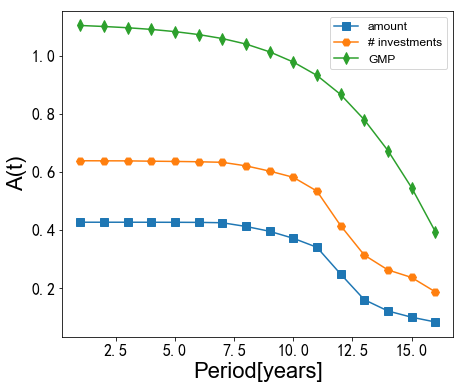

In [15]:
x=np.arange(1,17)
plt.figure(figsize=(7,6))
plt.plot(x,meanA,label='amount',marker='s',markersize=8)
plt.plot(x,meanT,label='# investments',marker='H',markersize=8)
plt.plot(x,meanG,label='GMP',marker='d',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 12,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Period[years]',font2)
plt.ylabel('A(t)',font2)
plt.legend(prop=font1,loc='upper right')
plt.savefig('E:/vcdata/pic/picSC/Fig6_a1_Atcity.pdf', bbox_inches='tight')

In [16]:
####计算城市自己的相关性 Ai(Dt) = 1DjiD2Xtji(t)ji(tzDt)
def AnumT(data,pop,m):###m代表第几行的城市
    corrCity = []###记录城市的相关性值  
    POP = data.iloc[m:m+1,0:18].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
    a = 0
    for xx in range(len(POP)):
        a += POP[xx]**2
    for t in range(1,11):
        Acity = [] ###记录每两年间的情况
        pop1 = data.iloc[m:m+1,0:len(pop)-t].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
        pop2 = data.iloc[m:m+1,t:18].fillna(0).values[0]
        b=0
        for j in range(len(pop1)):
            b+=pop1[j]*pop2[j]
        if a==0:
            corrCity.append(0)
        else:
            corrCity.append(b/a)
    return(corrCity)

In [17]:
###计算所有城市的delta t 时间序列相关性，并取均值###
TCity_A = []###投资金额，投资次数，GDP相关性
TCity_T = []
TCity_G = []
for n in range(dataM.shape[0]):
    TCity_A.append(AnumT(dataAmount,investment,n))
    TCity_T.append(AnumT(dataTimes,inv_times,n))
    TCity_G.append(AnumT(dataGDP,gdp,n))
dfT_A=pd.DataFrame(TCity_A)
dfT_T=pd.DataFrame(TCity_T)
dfT_G=pd.DataFrame(TCity_G)

meanTA = dfT_A.mean()
meanTT = dfT_T.mean()
meanTG = dfT_G.mean()

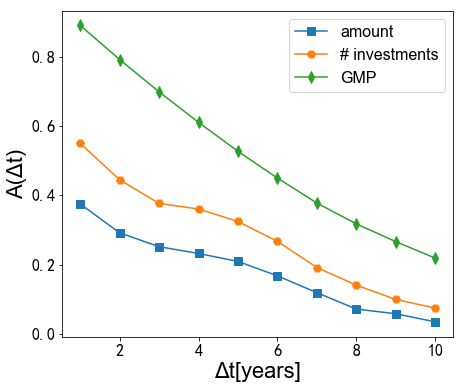

In [18]:
x=np.arange(1,11)
plt.figure(figsize=(7,6))
plt.plot(x,meanTA,label='amount',marker='s',markersize=8)
plt.plot(x,meanTT,label='# investments',marker='H',markersize=8)
plt.plot(x,meanTG,label='GMP',marker='d',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 16,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/vcdata/pic/picSC/Fig6_a2AdelT_city.pdf', bbox_inches='tight')

In [22]:
####计算城市两者之间的相关性 ######
def AnumT2(data,data2,pop,m):###m代表第几行的城市
    corrCity = []###记录城市的相关性值  
#     POP = data.iloc[m:m+1,0:18].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
#     a = 0
#     for xx in range(len(POP)):
#         a += POP[xx]**2
    for t in range(1,11):
        Acity = [] ###记录每两年间的情况
        pop1 = data.iloc[m:m+1,0:len(pop)-t].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
        pop2 = data2.iloc[m:m+1,t:18].fillna(0).values[0]
        a1=0
        a2=0
        for xx in range(len(pop1)):
            a1+=pop1[xx]**2
            a2+=pop2[xx]**2
        a=(a1**0.5)*(a2**0.5)
        b=0
        for j in range(len(pop1)):
            b+=pop1[j]*pop2[j]
        if a==0:
            corrCity.append(0)
        else:
            corrCity.append(b/a)
    return(corrCity)

In [20]:
###计算所有城市的delta t 时间序列相关性，并取均值###
# TCity_A = []###投资金额，投资次数，GDP相关性
TCity_AT = []
TCity_AG = []
for nn in range(dataM.shape[0]):
#     TCity_A.append(AnumT2(dataAmount,investment,n))
    TCity_AT.append(AnumT2(dataAmount,dataTimes,inv_times,nn))
    TCity_AG.append(AnumT2(dataAmount,dataGDP,gdp,nn))
# dfT_A=pd.DataFrame(TCity_A)
dfT_AT=pd.DataFrame(TCity_AT)
dfT_AG=pd.DataFrame(TCity_AG)

# meanTA = dfT_A.mean()
meanTAT = dfT_AT.mean()
meanTAG = dfT_AG.mean()

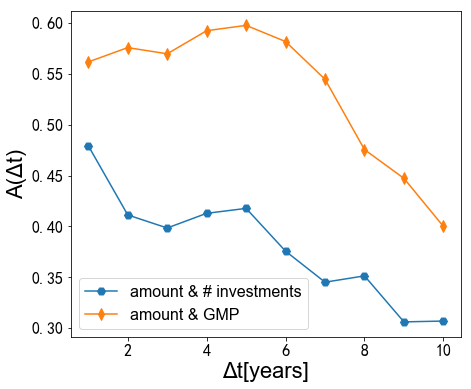

In [21]:
x=np.arange(1,11)
plt.figure(figsize=(7,6))
# plt.plot(x,meanTA,marker='o',label='amount')
plt.plot(x,meanTAT,marker='H',label='amount & # investments',markersize=8)
plt.plot(x,meanTAG,marker='d',label='amount & GMP',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 16,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/vcdata/pic/picSC/Fig6_a3(ΔA&TG-149).pdf', bbox_inches='tight')

In [22]:
###计算所有城市的delta t 时间序列相关性，并取均值###
# TCity_A = []###投资金额，投资次数，GDP相关性
TCity_GA = []
TCity_GT = []
for nn in range(dataM.shape[0]):
#     TCity_A.append(AnumT2(dataAmount,investment,n))
    TCity_GA.append(AnumT2(dataGDP,dataAmount,investment,nn))
    TCity_GT.append(AnumT2(dataGDP,dataTimes,inv_times,nn))
# dfT_A=pd.DataFrame(TCity_A)
dfT_GA=pd.DataFrame(TCity_GA)
dfT_GT=pd.DataFrame(TCity_GT)

# meanTA = dfT_A.mean()
meanTGA = dfT_GA.mean()
meanTGT = dfT_GT.mean()

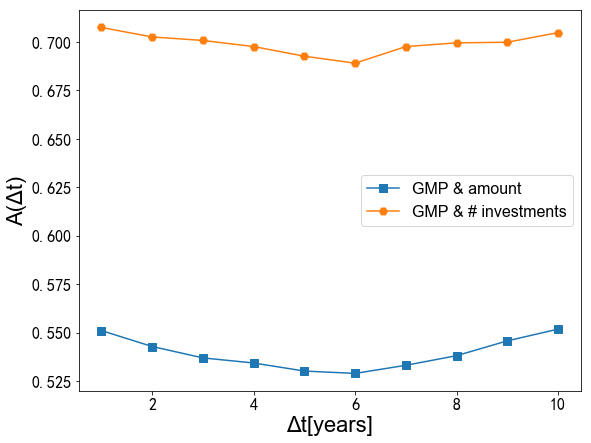

In [23]:
x=np.arange(1,11)
plt.figure(figsize=(9,7))
# plt.plot(x,meanTA,marker='o',label='amount')
plt.plot(x,meanTGA,marker='s',label='GMP & amount',markersize=8)
plt.plot(x,meanTGT,marker='H',label='GMP & # investments',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 16,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/vcdata/pic/picSC/Fig6_a4(ΔA&TG149).pdf', bbox_inches='tight')

In [24]:
###计算所有城市的delta t 时间序列相关性，并取均值###
# TCity_A = []###投资金额，投资次数，GDP相关性
TCity_TA = []
TCity_TG = []
for nn in range(dataM.shape[0]):
#     TCity_A.append(AnumT2(dataAmount,investment,n))
    TCity_TA.append(AnumT2(dataTimes,dataAmount,investment,nn))
    TCity_TG.append(AnumT2(dataTimes,dataGDP,gdp,nn))
# dfT_A=pd.DataFrame(TCity_A)
dfT_TA=pd.DataFrame(TCity_TA)
dfT_TG=pd.DataFrame(TCity_TG)

# meanTA = dfT_A.mean()
meanTTA = dfT_TA.mean()
meanTTG = dfT_TG.mean()

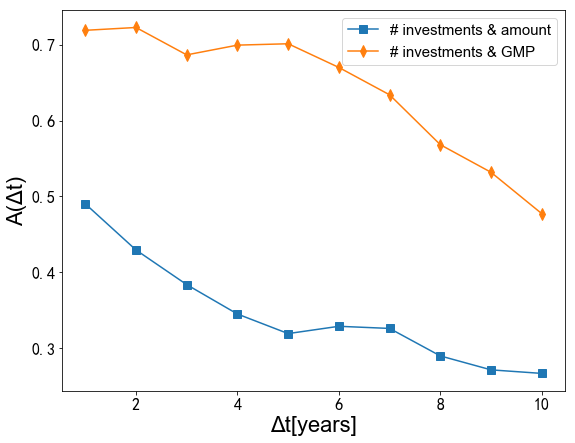

In [25]:
x=np.arange(1,11)
plt.figure(figsize=(9,7))
# plt.plot(x,meanTA,marker='o',label='amount')
plt.plot(x,meanTTA,marker='s',label='# investments & amount',markersize=8)
plt.plot(x,meanTTG,marker='d',label='# investments & GMP',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 15,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/vcdata/pic/picSC/Fig6_a5(ΔA&TG-149).pdf', bbox_inches='tight')

In [15]:
cityA = GuiJI(dataArea,pop,area,15,'pop','area')###按照2015年含有投资金额的城市来删选2000-2016年间关于GDP\amount\times的数据
dataA = pd.DataFrame(columns=dataArea.columns)
for cc in range(len(cityA)):
    if city[cc] in cityA:
#         print(cc)
        dataA.loc[cc] = list(dataArea[cc:cc+1].values[0])

In [26]:
dataAmount2 = dataA.iloc[:,11:29]###投资金额
dataAreas=dataA.iloc[:,20+27*5:40+27*5]###获取GDP的数据

In [27]:
dataAmount2[0:1]

,2000总投资金额(M),2001总投资金额(M),2002总投资金额(M),2003总投资金额(M),2004总投资金额(M),2005总投资金额(M),2006总投资金额(M),2007总投资金额(M),2008总投资金额(M),2009总投资金额(M),2010总投资金额(M),2011总投资金额(M),2012总投资金额(M),2013总投资金额(M),2014总投资金额(M),2015总投资金额(M),2016总投资金额(M),2017总投资金额(M)
0,NaN,NaN,NaN,NaN,NaN,NaN,8.72638,NaN,NaN,463.6,NaN,600.0,NaN,0.0,NaN,NaN,43.6,NaN


In [28]:
###计算所有城市的delta t 时间序列相关性，并取均值###
# TCity_A = []###投资金额，投资次数，GDP相关性
TCity_AA = []
TCity_AG = []
for nn in range(dataM.shape[0]):
    TCity_AG.append(AnumT2(dataAmount,dataGDP,gdp,nn))
for nn in range(dataA.shape[0]):
    TCity_AA.append(AnumT2(dataAmount2,dataAreas,area,nn))
# dfT_A=pd.DataFrame(TCity_A)
dfT_AA=pd.DataFrame(TCity_AA)
dfT_AG=pd.DataFrame(TCity_AG)

# meanTA = dfT_A.mean()
meanTAA = dfT_AA.mean()
meanTAG = dfT_AG.mean()

NameError: name 'dataM' is not defined

In [23]:
dataM

NameError: name 'dataM' is not defined